In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

In [4]:
import os
os.listdir("test_images/")
load_directory = "test_images/"
output_directory = "test_images_output/"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)

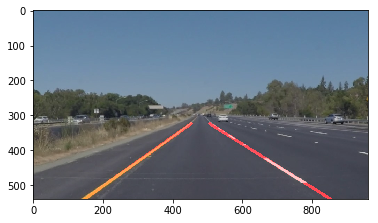

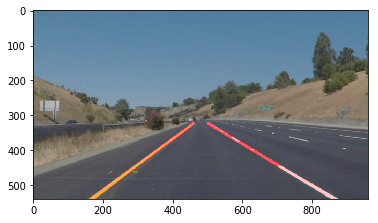

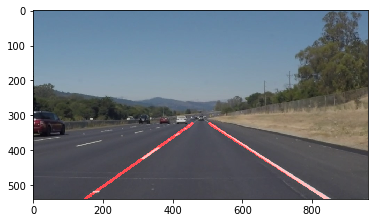

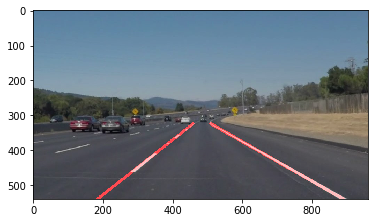

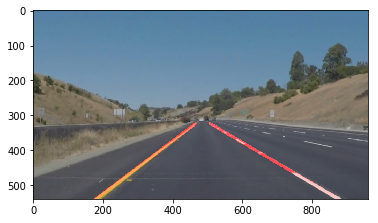

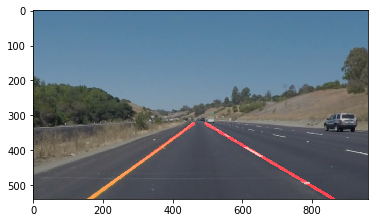

In [10]:
for file_name in os.listdir(load_directory):
    image = mpimg.imread(load_directory+file_name)

    #Turning RGB image to grayscale
    def grayscale(img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = grayscale(image)  
    #plt.imshow(gray,cmap='gray') 
    

    #setting gaussian blur for the image
    def gaussian_blur(img, kernel_size):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    kernel_size = 9
    blur_gray = gaussian_blur(gray,kernel_size) 
    #plt.imshow(blur_gray,cmap='gray')
    

    #Applying Canny edge detection
    def canny(img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold) 
    #plt.imshow(edges)
    

    #Setting Region of Interest
    def region_of_interest(img, vertices):
    
        mask = np.zeros_like(img)   
    
        if len(img.shape) > 2:
            channel_count = img.shape[2]  
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        
        cv2.fillPoly(mask, vertices, ignore_mask_color)
    
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image
    
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 325), (550, 325), (imshape[1],imshape[0])]], dtype=np.int32)  
    masked_edges = region_of_interest(edges, vertices)

    #plt.imshow(masked_edges)
    
    #Draw Lines function
    def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    
        left_lines = []
        left_slopes = []
        right_lines = []
        right_slopes = []
    
    
        right_x = []
        right_y = []
        left_x = []
        left_y = []

        #Statement to sort slope and intercept of line that fits data points
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                intercept = y1 - slope*x1
                if slope < 0:
                    left_lines.append((slope, intercept))
                    left_x.extend((x1,x2))
                    left_y.extend((y1,y2))
                
                else:
                    right_lines.append((slope , intercept))
                    right_x.extend((x1,x2))
                    right_y.extend((y1,y2))
                

        y1= img.shape[0]
        y2 = y1*0.6 

        #Simple fit for data points
        left_slp, left_int = np.polyfit(left_x,left_y,1)
        right_slp, right_int = np.polyfit(right_x,right_y,1)
    
        #generate values of x
        right_x1 = (y1-right_int)/right_slp
        right_x2 = (y2-right_int)/right_slp
    
        left_x1 = (y1-left_int)/left_slp
        left_x2 = (y2-left_int)/left_slp
    
        # Convert all to int
        y1 = int(y1)
        y2 = int(y2)
        right_x1 = int(right_x1)
        right_x2 = int(right_x2)
        left_x1 = int(left_x1)
        left_x2 = int(left_x2)

        cv2.line(img,(left_x1,y1),(left_x2,y2),color,thickness)
        cv2.line(img,(right_x1,y1),(right_x2,y2),color,thickness)



    #Hough Lines Transform
    def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        draw_lines(line_img, lines)
        return line_img
    
    rho = 0.8 
    theta = np.pi/180
    threshold = 25   
    min_line_len = 50 
    max_line_gap = 200

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    #plt.imshow(line_image)
    

    def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
        return cv2.addWeighted(initial_img, α, img, β, λ)
    lines_edges = weighted_img(line_image, image, α=0.8, β=1., λ=0.)
    plt.imshow(lines_edges)
    
    plt.show()
    
    mpimg.imsave(output_directory+file_name,lines_edges)




In [11]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

if not os.path.exists("test_videos_output/"):
    os.mkdir("test_videos_output/")
    
def process_image(image):
    gray = grayscale(image)
    kernel_size = 9
    blur_gray = gaussian_blur(gray,kernel_size)
    low_threshold = 90
    high_threshold = 180
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 325), (550, 325), (imshape[1],imshape[0])]], dtype=np.int32)  
    masked_edges = region_of_interest(edges, vertices)
    
    rho = 0.8 
    theta = np.pi/180
    threshold = 25   
    min_line_len = 50 
    max_line_gap = 200

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(line_image, image, α=0.8, β=1., λ=0.)

    return result


white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:10<00:00, 13.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 19 s, sys: 361 ms, total: 19.4 s
Wall time: 12.9 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:41<00:00, 12.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1min 3s, sys: 1.22 s, total: 1min 4s
Wall time: 42.5 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))